One of the major tasks that one aims to accomplish in Conversational AI is Natural Language Generation (NLG) which refers to employing models for the generation of natural language. In this article, we will get our hands on NLG by building an LSTM-based poetry generator. 

## Dataset

The dataset used for building the model has been obtained from Kaggle. The dataset is a compilation of poetries written by numerous poets present in the form of a text file. We can easily use this data to generate embeddings and subsequently train an LSTM model.

## Building the Text Generator

The text generator can be built in the following simple steps:

### Step 1. Import Necessary Libraries

Foremost, we need to import the necessary libraries. We are going to use TensorFlow with Keras for building the Bidirectional LSTM. 

In case any of the mentioned libraries are not installed, then just install it with pip install [package-name] command in the terminal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

### Step 2. Loading the Dataset and Exploratory Data Analysis

Now, we’ll load our dataset using pandas. Further, we need to perform some Exploratory Data Analysis so that we get to know our data better. As we are dealing with text data, the best way to do so is by generating a word cloud.

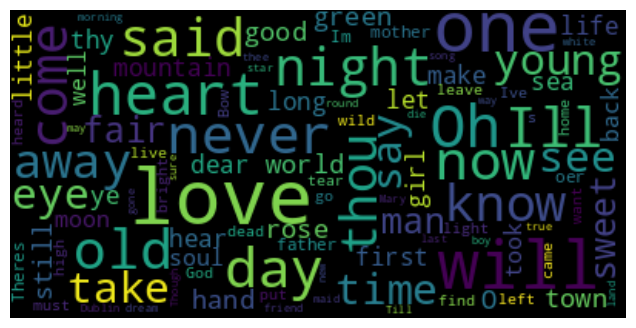

In [2]:
# Reading the text data file
data = open('poem.txt', encoding="utf8").read()
 
# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(data)
 
# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

### Step 3. Creating the Corpus

Now, we have all our data present in this massive text file. However, it is not recommended to feed our model with all the data altogether as it would lead to a lesser accuracy. Thus, we will be splitting our text into lines so that we can use them to generate text embeddings for our model.

In [3]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


### Step 4. Fitting the Tokenizer on the Corpus

In order to generate the embeddings later, we need to fit a TensorFlow Tokenizer on the entire corpus so that it learns the vocabulary.  

In [4]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
 
# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)
 
print("Total Words:", total_words)

Total Words: 3807


### Step 5. Generating Embeddings/Vectorization

Now we will generate embeddings for each sentence in our corpus. Embeddings are vectorized representations of our text. Since we cannot feed Machine/Deep Learning models with unstructured text, this is an imperative step. Firstly, we convert each sentence to embedding using Keras’ text_to_sequence() function. Then we compute the length of the longest embedding; finally, we pad all the embeddings to that maximum length with zeros so as to ensure embeddings of equal length.

In [5]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
 
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_len,
                                         padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)

This is how our text embeddings would look like:

array([[   0,    0,    0, …,    0,    0,  266],

       [   0,    0,    0, …,    0,  266,    3],

       [   0,    0,    0, …,    0,    0,    4],

       …,

       [   0,    0,    0, …,    8, 3807,   15],

       [   0,    0,    0, …, 3807,   15,    4],

       [   0,    0,    0, …,   15,    4,  203]], dtype=int32)

### Step 6. Building the Bi-directional LSTM Model 

By now, we are done with all the pre-processing steps that were required in order to feed the text to our model. Its time now that we start building the model. Since this is a use case of text generation, we will create a Bi-directional LSTM model as meaning plays an important role here. 

In [6]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100,
                    input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           380800    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3807)              384507    
                                                                 
 dense_1 (Dense)             (None, 3808)              14500864  
                                                        

The model will work on a next-word-prediction-based approach wherein we will input a seed text, and the model will generate poetry by predicting the subsequent words. This is why we have used a softmax activation function which is generally used for multi-class classification use cases. 

### Step 7. Model Training

Having built the model architecture, we’ll now train it on our pre-processed text. Here, we have trained our model for 150 Epochs. 

In [7]:
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
510/510 [==============================] - 34s 34ms/step - loss: 6.9555 - accuracy: 0.0619
Epoch 2/150
510/510 [==============================] - 7s 13ms/step - loss: 6.5233 - accuracy: 0.0635
Epoch 3/150
510/510 [==============================] - 5s 10ms/step - loss: 6.3372 - accuracy: 0.0655
Epoch 4/150
510/510 [==============================] - 5s 10ms/step - loss: 6.2130 - accuracy: 0.0743
Epoch 5/150
510/510 [==============================] - 5s 10ms/step - loss: 6.1185 - accuracy: 0.0778
Epoch 6/150
510/510 [==============================] - 6s 11ms/step - loss: 6.0231 - accuracy: 0.0855
Epoch 7/150
510/510 [==============================] - 5s 10ms/step - loss: 5.9057 - accuracy: 0.0938
Epoch 8/150
510/510 [==============================] - 6s 11ms/step - loss: 5.7968 - accuracy: 0.1017
Epoch 9/150
510/510 [==============================] - 5s 10ms/step - loss: 5.7023 - accuracy: 0.1064
Epoch 10/150
510/510 [==============================] - 6s 12ms/step - loss: 5.61

###Step 8. Generating Text using the Built Model

In the final step, we will generate poetry using our model. As stated earlier, the model is based upon a next-word prediction approach – hence, we need to provide the model with some seed text.

In [8]:
seed_text = "The world"
next_words = 25
ouptut_text = ""
 
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list,
                                        verbose=0), axis=-1)
    output_word = ""
     
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
             
    seed_text += " " + output_word
     
print(seed_text)

The world seems bright and gay made me gone in a rock leg from morn with gold and ireland god is my grief are wonder sound of


Finally, we have built a model from scratch that generates poetry given an input seed text. The model can be made to generate even better results by using a larger training dataset and fiddling with the model parameters. 